In [52]:
import qelos as q
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
import os
import numpy
import sklearn
import sklearn.datasets

%matplotlib inline
from qelos.scripts.wgan.ganutil import ImageGenerator
# clean imports
from matplotlib import pyplot
from matplotlib import gridspec
import IPython
from datetime import datetime as dt
import pandas as pd

In [53]:
opt_onesided = False     # use two-sided or one-sided constraint

opt_penalty_weight = 10.0 # penalty weight term lambda

opt_lip_mode = "WGAN"
opt_dataset = 'swissroll' # 8gaussians | swissroll | 25gaussians
opt_niter = 5000
opt_batchSize=256
opt_lrD = 0.00005 # learning rate for Critic, default=0.00005
opt_lrG = 0.00005 # learning rate for Generator, default=0.00005
opt_beta1=0.5 # beta1 for adam. default=0.5
opt_cuda = torch.cuda.is_available()
opt_clamp_lower = -0.01 #default -0.01
opt_clamp_upper =  0.01 #default  0.01
opt_Diters = 10 # number of D iters per each G iter
opt_adam = False  # Whether to use adam (default False is rmsprop)
opt_prefix = None # whether to write images (=prefix of type string) or show in notebook (=None)

opt_manualSeed = 15042017
print("Random Seed: ", opt_manualSeed)
random.seed(opt_manualSeed)
numpy.random.seed(opt_manualSeed)
torch.manual_seed(opt_manualSeed)
cudnn.benchmark = True

('Random Seed: ', 15042017)


In [54]:
# Dataset generator largely form Improved Training of Wasserstein GAN code (see link above)
def inf_train_gen(DATASET='8gaussians', BATCH_SIZE=opt_batchSize, seed=1234):
    numpy.random.seed(seed)
    if DATASET == '25gaussians':
        dataset = []
        for i in range(100000//25):
            for x in range(-2, 3):
                for y in range(-2, 3):
                    point = numpy.random.randn(2)*0.05
                    point[0] += 2*x
                    point[1] += 2*y
                    dataset.append(point)
        dataset = numpy.array(dataset, dtype='float32')
        numpy.random.shuffle(dataset)
        dataset /= 2.828 # stdev
        while True:
            for i in range(len(dataset)//BATCH_SIZE):
                yield torch.from_numpy(dataset[i*BATCH_SIZE:(i+1)*BATCH_SIZE])

    elif DATASET == 'swissroll':

        while True:
            data = sklearn.datasets.make_swiss_roll(
                n_samples=BATCH_SIZE, 
                noise=0.25
            )[0]
            data = data.astype('float32')[:, [0, 2]]
            data /= 7.5 # stdev plus a little
            yield torch.from_numpy(data)

    elif DATASET == '8gaussians':
    
        scale = 2.
        centers = [
            (1,0),
            (-1,0),
            (0,1),
            (0,-1),
            (1./numpy.sqrt(2), 1./numpy.sqrt(2)),
            (1./numpy.sqrt(2), -1./numpy.sqrt(2)),
            (-1./numpy.sqrt(2), 1./numpy.sqrt(2)),
            (-1./numpy.sqrt(2), -1./numpy.sqrt(2))
        ]
        centers = [(scale*x,scale*y) for x,y in centers]
        while True:
            dataset = []
            for i in range(BATCH_SIZE):
                point = numpy.random.randn(2)*.02
                center = random.choice(centers)
                point[0] += center[0]
                point[1] += center[1]
                dataset.append(point)
            dataset = numpy.array(dataset, dtype='float32')
            dataset /= 1.414 # stdev
            yield torch.from_numpy(dataset)

In [55]:
class InfIterOver(object):
    def __init__(self, *tensors, **kw):   # must be torch tensors
        batsize = 2
        if "batch_size" in kw:
            batsize = kw["batch_size"]
        self.tensors = tensors
        self.dataset = q.TensorDataset(*tensors)
        self.dataloader = DataLoader(self.dataset, batch_size=batsize, shuffle=True)
        self.dataiter = iter(self.dataloader)
        self.epochcounter = 0
        print(batsize)
        print(len(self.dataloader))
        print(tensors[0].size())
        
    def __next__(self):
        try:
            ret = next(self.dataiter)
        except StopIteration as e:
            self.epochcounter += 1
            print("new epoch: {}".format(self.epochcounter))
            self.dataiter = iter(self.dataloader)   # restart iter on dataloader
            ret = next(self.dataiter)
        return ret
    
    next = __next__
    
    def __iter__(self):
        return self
    
    def __len__(self):
        return len(self.dataloader)

In [56]:
ds1 = [next(inf_train_gen("swissroll")) for i in range(100)]
ds2 = [next(inf_train_gen("swissroll")) for i in range(100)]
for ds1e, ds2e in zip(ds1, ds2):
    assert(numpy.allclose(ds1e.numpy(), ds2e.numpy()))

In [57]:
class ToyGAN_G(nn.Module):
    def __init__(self, dim_hidden=512, dim_out=2, noise_dim=2):
        super(ToyGAN_G, self).__init__()
        self.dim_hidden, self.dim_out, self.noise_dim = dim_hidden, dim_out, noise_dim
        self.net = nn.Sequential(
            nn.Linear(noise_dim, dim_hidden),
            nn.LeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(),
            nn.Linear(dim_hidden, dim_out)
            )
    def forward(self, x):
        x = self.net(x)
        return x

class ToyGAN_D(nn.Module):
    def __init__(self, dim_hidden=512, dim_gen_out=2):
        super(ToyGAN_D, self).__init__()
        self.dim_hidden, self.dim_gen_out = dim_hidden, dim_gen_out
        self.net = nn.Sequential(
            nn.Linear(dim_gen_out, dim_hidden),
            nn.LeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(),
            nn.Linear(dim_hidden, 1)
            )
    def forward(self, x): #?
        x = self.net(x)
        return x

In [58]:
class Settings(object):
    def __init__(self, **kw):
        self.dic = kw
        
    def __getattr__(self, x):
        return self.dic[x]

In [59]:
class AccLogger(object):
    def __init__(self, follow=None):
        self.follow = follow       
        self.errD = []
        self.errG = []
        self.scoreD_real = []
        self.scoreD_fake = []
        self.lip_loss = []
        self.valid_EMD = []

    def log(self, errD=None, errG=None, scoreD_real=None, scoreD_fake=None, lip_loss=None, valid_EMD=None, **kw):
        self.errD.append(errD)
        self.errG.append(errG)
        self.scoreD_real.append(scoreD_real)
        self.scoreD_fake.append(scoreD_fake)
        self.lip_loss.append(lip_loss)
        self.valid_EMD.append(valid_EMD)
        if self.follow is not None:
            self.follow.log(errD=errD, errG=errG, scoreD_real=scoreD_real, scoreD_fake=scoreD_fake, lip_loss=lip_loss, valid_EMD=valid_EMD, **kw)
        
    def get_acc(self):
        return self.errD, self.errG, self.scoreD_real, self.scoreD_fake, self.lip_loss, self.valid_EMD
    
    
class ProgressLogger(object):
    def __init__(self, imggen, follow=None, iterval=50, settings=None, lossplot="errD"):
        self.lossplot = lossplot
        self.follow = follow
        self.imggen = imggen
        self.iterval = iterval
        self.losses = []
        self.settings = settings
        
    def log(self, _iter=None, niter=None, errD=None, errG=None, scoreD_real=None, scoreD_fake=None, lip_loss=None, 
            real=None, grad_points=None, valid_EMD=None, valid_fake2real=None, valid_real2fake=None, valid_fakeandreal=None, **kw):
        if (_iter+1) % self.iterval == 0:
          toplot = errD
          if self.lossplot == "fnr":
            toplot = valid_fakeandreal
          elif self.lossplot == "emd":
            toplot = valid_EMD
          self.losses.append(toplot)   # was errD
          imgret = self.imggen(real, grad_points, self.losses)
          print("Method: {} with penalty weight {}, {}-sided penalty".format(self.settings.lip_mode, self.settings.penalty_weight, "one" if self.settings.onesided else "two"))
          print('[%d/%d] Loss_D: %f Loss_G: %f Score_D_real: %f Score_D_fake %f Loss_lip %f \n Valid_EMD %f Valid_f2r %f Valid_r2f %f Valid_fnr %f'
            % (_iter+1, niter, errD, errG, scoreD_real, scoreD_fake, lip_loss, valid_EMD, valid_fake2real, valid_real2fake, valid_fakeandreal))
        if self.follow is not None:
            self.follow.log(_iter=_iter, niter=niter, errD=errD, errG=errG, scoreD_real=scoreD_real, scoreD_fake=scoreD_fake, lip_loss=lip_loss, grad_points=grad_points, real=real, valid_EMD=valid_EMD, valid_fake2real=valid_fake2real, valid_real2fake=valid_real2fake, valid_fakeandreal=valid_fakeandreal, **kw)

In [60]:
def run_experiment(lip_mode=opt_lip_mode,    # WGAN/DRAGAN/PAGAN...
                   onesided = opt_onesided,
                   penalty_weight = opt_penalty_weight, 
                   perturb_both = False, 
                   perturb_symmetric = False,
                   perturb_scale=1.,
                   niter=opt_niter,
                   modeD="critic",
                   dataset="swissroll",
                   cuda=opt_cuda,
                   batsize=256,
                   validbatsize=500,
                   numbats=None,                      # None--> infinite batches, int --> fixed batches will be iterated over
                   save_frames_to_pdf=False,
                   valid_emd=False,
                   iterval=10, # Adapt this when saving frames or computing emd 
                   paganp=2):
    print("using cuda: {}".format(cuda))
    
    netG = ToyGAN_G()
    netD = ToyGAN_D()
    
    if opt_adam:
        optD = optim.Adam(netD.parameters(), lr=opt_lrD)
        optG = optim.Adam(netG.parameters(), lr=opt_lrG)
    else:
        optD = optim.RMSprop(netD.parameters(), lr=opt_lrD)
        optG = optim.RMSprop(netG.parameters(), lr=opt_lrG)
        
    imggen = ImageGenerator(netG, netD, prefix=opt_prefix, save_frames_to_pdf=save_frames_to_pdf)
    settings = Settings(lip_mode=lip_mode, onesided=onesided, penalty_weight=penalty_weight, niter=niter, 
                        perturb_both=perturb_both, perturb_symmetric=perturb_symmetric, perturb_scale=perturb_scale)
    
    plogger = ProgressLogger(imggen, iterval=iterval,
                            settings=settings, lossplot="emd" if valid_emd else "fnr")
    alogger = AccLogger(follow=plogger)
    
    gantrainer = q.GANTrainer(mode=lip_mode, modeD=modeD, paganP=paganp, one_sided=onesided, penalty_weight=penalty_weight, 
                              perturb_both=perturb_both, perturb_symmetric=perturb_symmetric, perturb_scale=perturb_scale, 
                              clamp_weights_rng=(opt_clamp_lower, opt_clamp_upper), optimizerD=optD, optimizerG=optG, 
                              logger=alogger, validinter=iterval, notgan=False, validation_metrics=["emd" if valid_emd else "fnr"])
    
    if numbats is None:
        datagen = inf_train_gen(dataset, batsize)
    else:
        def iter_unwrap(iterator):
            while True:
                yield next(iterator)[0]
        datagen = iter_unwrap(InfIterOver(next(inf_train_gen(dataset, batsize * numbats)), batch_size=batsize))
    
    def iter_constant(constant):
        while True:
            yield constant
    fixedvaliddatagen = iter_constant(next(inf_train_gen(dataset, validbatsize, seed=123456)))
    
    gantrainer.train(netD, netG, niter=niter, niterD=10, batsizeG=batsize, data_gen=datagen,
                     valid_data_gen=fixedvaliddatagen, cuda=cuda)
    
    imggen.finalize(settings=settings)
    
    return alogger.get_acc()

In [48]:
# test different datagen unrolls produce same data seq
def f():
    def iter_unwrap(iterator):
        while True:
            yield next(iterator)[0]
    datagen = iter_unwrap(InfIterOver(next(inf_train_gen("swissroll", 10 * 10)), batch_size=10))
    return datagen

f1 = f()
f2 = f()
f1 = [next(f1) for i in range(10)]
f2 = [next(f2) for i in range(10)]

for x, y in zip(f1, f2):
    assert(numpy.allclose(x.numpy(), y.numpy()))

# !! will not be same because DataLoader inside InfIterOver shuffles --> TODO



10
10
torch.Size([100, 2])
10
10
torch.Size([100, 2])


AssertionError: 

In [61]:
def run_n_experiments(n=1, savedir="experiments/", savename=None, save=True,
                      lip_mode=opt_lip_mode,
                      onesided=opt_onesided,
                      penalty_weight=opt_penalty_weight,
                      perturb_both=False,
                      perturb_symmetric=False,
                      niter=opt_niter,
                      modeD="critic", 
                      **kw):
    names = "WGAN WGAN-GP DRAGAN DRAGAN-G DRAGAN-LG".split()
    
    mat = numpy.zeros((niter, n, 6))
    cols = ["errD", "errG", "scoreD_real", "scoreD_fake", "lip_loss", "valid_EMD"]
    for ni in range(n):
        print("running {} of {}".format(ni, n))
        
        errD, errG, scoreD_real, scoreD_fake, lip_loss, valid_EMD = run_experiment(lip_mode=lip_mode, 
                                                                        onesided=onesided, 
                                                                        penalty_weight=penalty_weight, 
                                                                        perturb_both=perturb_both,
                                                                        perturb_symmetric=perturb_symmetric,
                                                                        niter=niter,
                                                                        modeD=modeD,
                                                                        **kw)
        mat[:, ni, 0] = errD
        mat[:, ni, 1] = errG
        mat[:, ni, 2] = scoreD_real
        mat[:, ni, 3] = scoreD_fake
        mat[:, ni, 4] = lip_loss
        mat[:, ni, 5] = valid_EMD
        
    multiindex = [reduce(lambda x, y: x + y, [[i+1]*mat.shape[1] for i in range(mat.shape[0])], []),
                  reduce(lambda x, y: x + y, [[j+1 for j in range(mat.shape[1])] for i in range(mat.shape[0])], [])]
    
    flatmat = mat.reshape((-1, mat.shape[-1]))
    #flatmat = np.concatenate([np.asarray(multiindex).T, flatmat], axis=1)
    mi = pd.MultiIndex.from_arrays(multiindex, names="iter run".split())
    df = pd.DataFrame(flatmat, index=mi, columns=cols)
    
    if savename is None:
        extraoptstring = ""
        if lip_mode in "DRAGAN DRAGAN-G DRAGAN-LG":
            extraoptstring += "_pboth={}".format(int(perturb_both))
        if lip_mode == "DRAGAN":
            extraoptstring += "_psym={}".format(int(perturb_symmetric))
        savename = "{}_os={}_pw={}{}_niter={}_at_{}".format(
            lip_mode, int(onesided), penalty_weight, extraoptstring, niter,
            str(dt.now()).replace(" ", "_"))
    savep = savedir + savename
    if save:
        df.to_csv(savep)
        loadeddf = pd.read_csv(savep, index_col=[0, 1], skipinitialspace=True)
        #return loadeddf
    return df

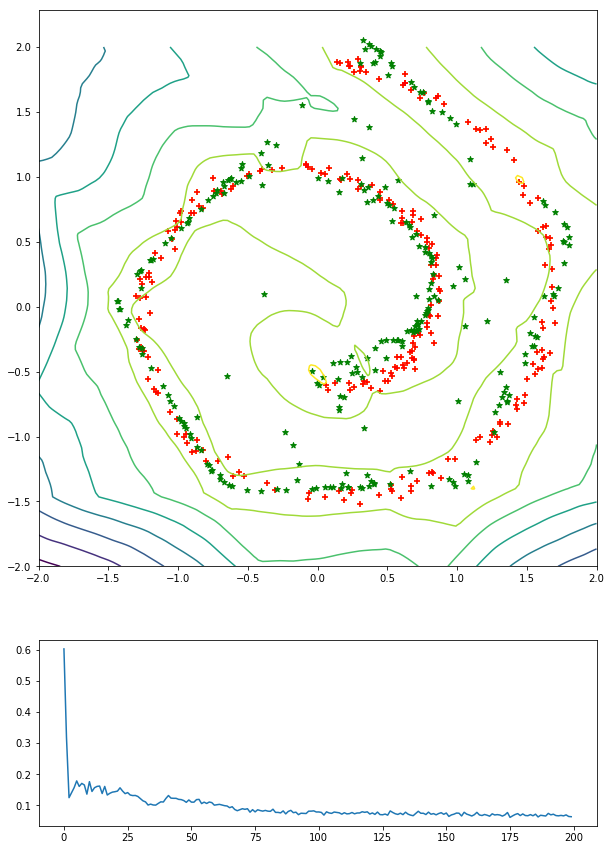

Method: DRAGAN with penalty weight 5, two-sided penalty
[2000/2000] Loss_D: 0.023132 Loss_G: -2.820430 Score_D_real: 2.852863 Score_D_fake 2.831074 Loss_lip 0.044921 
 Valid_EMD 0.000000 Valid_f2r 0.075004 Valid_r2f 0.054746 Valid_fnr 0.063294


errD      errG  scoreD_real  scoreD_fake  lip_loss  valid_EMD
iter run                                                                   
1    1   -1.510794  1.162282     0.469662    -1.183088  0.141956        0.0
     2   -2.021260  0.938709     1.173947    -0.971454  0.124141        0.0
     3   -2.112549  1.229608     1.158597    -1.176318  0.222367        0.0
     4   -1.821852  1.562633     0.359252    -1.598612  0.136011        0.0
     5   -2.074040  1.213277     0.975155    -1.253028  0.154143        0.0
     6    0.437307  1.597966    -1.944918    -1.581436  0.073825        0.0
     7   -2.140138  0.873504     1.376031    -0.910031  0.145924        0.0
     8   -2.197019  1.028381     1.256029    -1.069027  0.128037        0.0
     9    0.070338  1.902687    -1.855786    -1.868801  0.083353        0.0
     10  -1.899317  1.142280     0.759360    -1.232690  0.092733        0.0
     11  -0.173328  1.931210    -1.656167    -1.920234  0.090739        0.0
     12  -1.998399  1.017834     1.071337    -1.069513  0.142451        0.0
     13  -1.968203  0.937707     1.096210    -1.007552  0.135559        0.0
     14  -2.136128  1.089001     1.207174    -1.096600  0.167646        0.0
     15  -0.381917  2.127336    -1.660121    -2.114139  0.072102        0.0
     16  -1.818484  1.426598     0.605954    -1.361040  0.148510        0.0
     17  -1.829880  1.302003     0.705033    -1.253286  0.128439        0.0
     18  -1.991511  0.926414     1.165502    -0.953567  0.127557        0.0
     19  -1.634567  1.186004     0.546943    -1.212476  0.124851        0.0
     20  -1.787109  1.120466     0.846622    -1.073326  0.132839        0.0
2    1   -1.919198  2.029503     0.074003    -2.020378  0.175183        0.0
     2   -2.205289  1.275764     1.248467    -1.324672  0.367850        0.0
     3   -2.145543  1.785555     0.665583    -1.794580  0.314620        0.0
     4   -2.616282  3.058458    -0.089839    -2.997217  0.291096        0.0
     5   -2.288248  1.702309     1.137333    -1.613882  0.462967        0.0
     6   -1.456757  4.447748    -2.513803    -4.441969  0.471410        0.0
     7   -2.717562  1.654064     1.526867    -1.549062  0.358367        0.0
     8   -3.568372  1.958107     1.990648    -1.991369  0.413646        0.0
     9   -1.901138  4.625206    -2.402132    -4.641966  0.338696        0.0
     10  -2.067150  1.798105     0.555533    -1.785290  0.273674        0.0
...            ...       ...          ...          ...       ...        ...
1999 11   0.035763 -1.033313     0.985519     0.986679  0.034602        0.0
     12   0.081023  0.016188    -0.076884    -0.104225  0.108364        0.0
     13   0.047692 -4.261616     4.235167     4.258347  0.024512        0.0
     14   0.165726 -3.592525     3.645760     3.637848  0.173638        0.0
     15   0.099877 -0.223753     0.263055     0.289308  0.073624        0.0
     16   0.049034 -0.548026     0.522923     0.532581  0.039376        0.0
     17   0.067333 -0.737047     0.694080     0.707113  0.054300        0.0
     18   0.145519  0.082921     0.045004     0.078361  0.112162        0.0
     19   0.027050  0.966328    -1.012563    -1.029091  0.043578        0.0
     20  -0.000166 -2.837140     2.783270     2.751011  0.032092        0.0
2000 1    0.068416 -1.165815     1.170376     1.156514  0.082277        0.0
     2    0.127684 -3.127796     3.004208     3.072618  0.059274        0.0
     3    0.069623  0.288500    -0.358553    -0.352496  0.063566        0.0
     4    0.040787 -2.125278     2.187925     2.198594  0.030118        0.0
     5    0.029284 -1.537720     1.471745     1.460232  0.040797        0.0
     6    0.049554 -1.842317     1.894016     1.907974  0.035595        0.0
     7    0.139307 -2.692783     2.827985     2.801211  0.166080        0.0
     8    0.033508  0.156899    -0.249411    -0.264159  0.048256        0.0
     9    0.126321 -2.614053     2.580584     2.625659  0.081246        0.0
     10   0.050773 -0.409849     0.428231     0.441484  0.0375

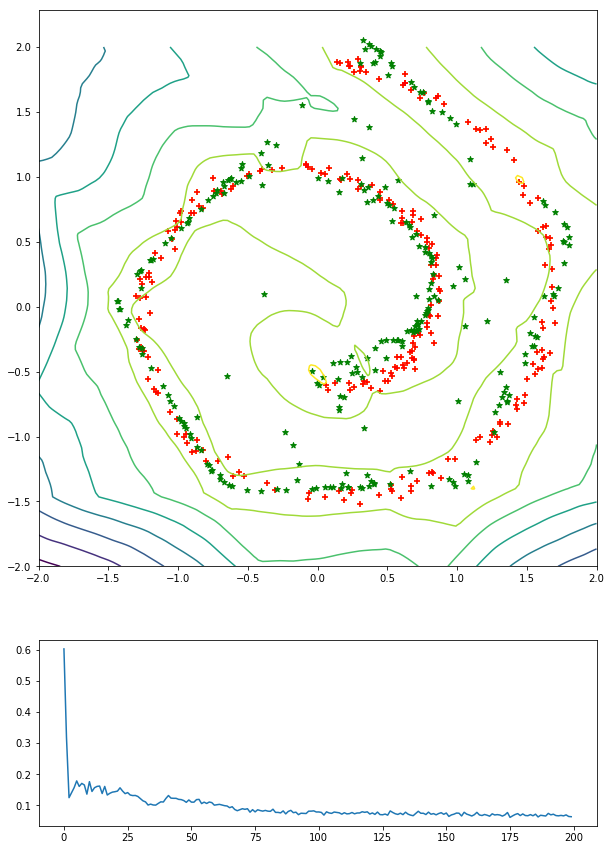

In [ ]:
run_n_experiments(n=20, lip_mode="DRAGAN", penalty_weight=5, onesided=False, niter=2000, perturb_scale=0)

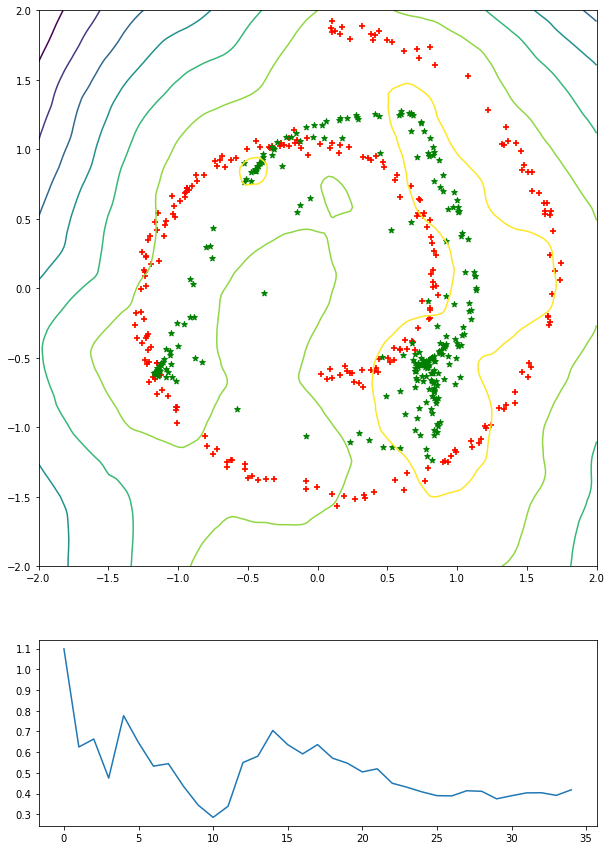

Method: DRAGAN with penalty weight 10, two-sided penalty
[350/500] Loss_D: 0.480768 Loss_G: 1.977955 Score_D_real: -2.279608 Score_D_fake -2.055681 Loss_lip 0.256840 
 Valid_EMD 0.418510 Valid_f2r 0.000000 Valid_r2f 0.000000 Valid_fnr 0.000000


In [ ]:
run_n_experiments(n=10, lip_mode="DRAGAN", penalty_weight=10, perturb_scale=0, onesided=False, niter=500, valid_emd=True, iterval=10, validbatsize=500)

In [12]:
def run_list_of_experiments(*specs, **kw):  # specs must be dictionaries (see example in next cell)
    for spec in specs:
        # rename long kw names
        rename_dic = {"lm": "lip_mode", 
                      "pw": "penalty_weight", 
                      "os": "onesided", 
                      "pboth": "perturb_both", 
                      "psym": "perturb_symmetric", 
                      "pscale": "perturb_scale"}
        for rde in rename_dic:
            if rde in spec:
                spec[rename_dic[rde]] = spec[rde]
                del spec[rde]
        speckw = {}
        speckw.update(kw)
        speckw.update(spec)
        run_n_experiments(**speckw)

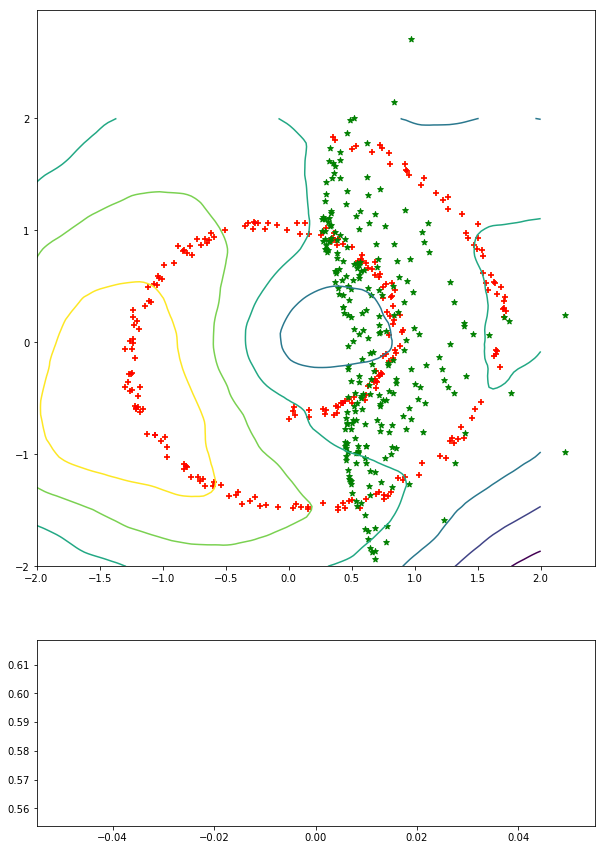

Method: DRAGAN with penalty weight 10, one-sided penalty
[10/2000] Loss_D: -0.782019 Loss_G: 3.638542 Score_D_real: -2.796084 Score_D_fake -3.602424 Loss_lip 0.024322 
 Valid_EMD 0.000000 Valid_f2r 0.440765 Valid_r2f 0.874588 Valid_fnr 0.586136


KeyboardInterrupt: 

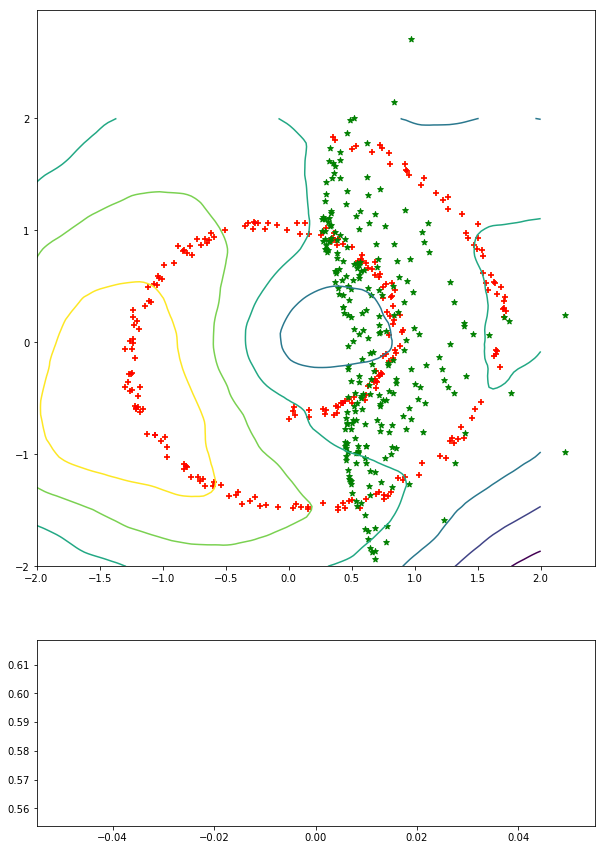

In [62]:
run_experiment(lip_mode="DRAGAN", penalty_weight=10, onesided=True, niter=2000, perturb_scale=0)

In [15]:
run_list_of_experiments({"n":5, "lm": "DROGAN", "pw": 10, "os": True, "niter"=20, "valid_emd"=True},
                        {"n":5, "lm": "DROGAN", "pw": 10, "os": False, "niter"=20, "valid_emd"=True},
                        niter=500)

SyntaxError: invalid syntax (<ipython-input-15-f733ed32f04d>, line 1)

KeyboardInterrupt: 

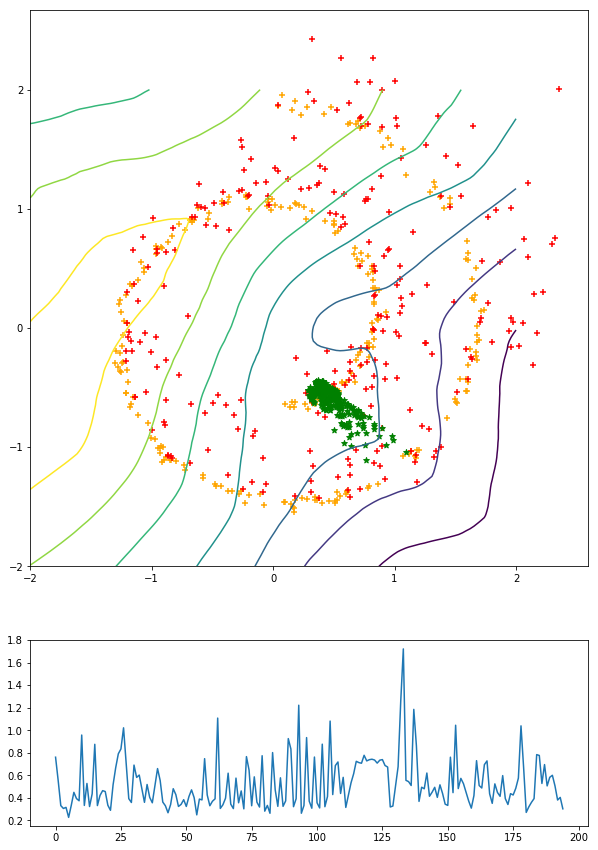

In [16]:
_ = run_experiment(lip_mode="DRAGAN", cuda=True, onesided=False, penalty_weight=10, perturb_both=True, save_frames_to_pdf=False, niter=2000, numbats=100, valid_emd=True)

In [ ]:
run_experiment(lip_mode="DRAGAN-LG", penalty_weight=10., onesided=True, perturb_scale=0.25, niter=5000, cuda=True)